<a href="https://colab.research.google.com/github/pgnepal/pytorch-examples/blob/master/Analytics_Connect_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Practical Deep Learning with Python




# SUPERVISED CLASSIFICATION FROM SCRATCH
## [Useful when you have lots of data with corresponding labels]

## PyTorch and Tensors

In [0]:
import torch
import torch.nn as nn # layers with trainable parameters
import torch.nn.functional as F  # arithmetic operations 
import torch.optim as optim

from tqdm import tnrange, tqdm_notebook
torch.manual_seed(8451)

# change device to gpu - Edit -> Notebook Settings -> Hardware Accelerator -> GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device: {}'.format(torch.cuda.get_device_name(device=device) if 
                                device.type == 'cuda' else 'cpu'))


Using device: Tesla P100-PCIE-16GB


In [0]:
# Tensors are a generalaization of matrices to N dimensions]

# vector: 1d tensor
V = torch.tensor([1,2,3,4,5])
print('vector: {}\n'.format(V))

# matrix: 2d tensor
M = torch.tensor([[1., 2., 3.], [4., 5., 6]])
print('matrix: {}\n'.format(M))

# 3d tensor of size 2x2x2.
T_data = [[[1., 2.], [3., 4.]],
          [[5., 6.], [7., 8.]]]

T = torch.tensor(T_data)
print('3D tensor: {}'.format(T))

vector: tensor([1, 2, 3, 4, 5])

matrix: tensor([[1., 2., 3.],
        [4., 5., 6.]])

3D tensor: tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])


In [0]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


## Load and Transform CIFAR-10 Data using Torchvision



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


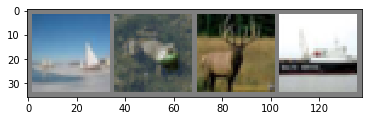

 ship  frog  deer  ship


In [0]:
# Load and transform the Canadian Institute for Advanced Research CIFAR-10 training 
# and validation datasets using torchvision
# The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size

# To load custom images and apply custom transforms see, 
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


# define data transforms (e.g normalization)
# https://pytorch.org/docs/stable/torchvision/transforms.html
# torchvision.transforms.Normalize(mean, std, inplace=False)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# load CiFAR10 training set 
num_train_samples = 5000
num_validation_samples = 2500
batch_size = 4

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(range(num_train_samples)))

validation_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2, 
                                         sampler=torch.utils.data.sampler.SubsetRandomSampler(range(num_validation_samples)))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(trainloader)
images, labels = data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



## Define a Convolutional Neural Network 

In [0]:
# layers:
## torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
## torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
## torch.nn.Linear(in_features, out_features, bias=True)
## torch.nn.ReLU(inplace=False) -  max(0,x)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

## Network Print / Summary

In [0]:
# http://cs231n.github.io/convolutional-networks/
from torchsummary import summary
net = Net()
net.to(device)
print(net)
summary(net, (3, 32, 32))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainabl

## Define Loss Function and Optimizer


In [0]:
# combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
## Softmax: normalizes input vector into probabiity distribution. Generalization of logistic regression to multiple classes
## NLL LOSS. negative log-likelihood of the true labels given probabilistic classifier predictions
criterion = nn.CrossEntropyLoss() 

# Stochastic Gradient Descent with momentum
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


## Train Neural Network

In [0]:
# validation accuracy checker
def val_accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# define network, loss, and optimizer
net = Net() 
net.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

# train network
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # compute validation accuracy
    val_acc = val_accuracy(net, validationloader)
         
    # print statistics every epoch
    print('[epoch: {}] training loss: {:.3f}' ' validation accuracy: {} '.format
              (epoch + 1, running_loss / (num_train_samples / batch_size), val_acc))
    running_loss = 0.0

print('Finished Training')

[epoch: 1] training loss: 2.303 validation accuracy: 10.52 
[epoch: 2] training loss: 2.300 validation accuracy: 11.04 
[epoch: 3] training loss: 2.296 validation accuracy: 13.36 
[epoch: 4] training loss: 2.290 validation accuracy: 16.0 
[epoch: 5] training loss: 2.275 validation accuracy: 16.84 
[epoch: 6] training loss: 2.244 validation accuracy: 19.72 
[epoch: 7] training loss: 2.181 validation accuracy: 24.88 
[epoch: 8] training loss: 2.093 validation accuracy: 26.32 
[epoch: 9] training loss: 2.016 validation accuracy: 27.88 
[epoch: 10] training loss: 1.970 validation accuracy: 30.84 
Finished Training


## Exercise
Try to get training loss below 1 and improve validation accuracy without changing number of epochs and training / test data. 
ideas: change batchsize, learning rate, new optimizer, network layers

# SUPERVISED CLASSIFICATION WITH TRANSFER LEARNING
## [Useful when you have little data with corresponding labels]

# *TRANSFER LEARNING*: **Storing knowledge** gained from solving a problem and applying it **to solve another related problem**

## Why Transfer Learning
*   It is usually difficult to obtain **large labeled data, compute, and DL architectural designs** required to solve complex problems from unstructured data in practice. 

#   Transfer Learning Scenarios
*   Pretrained Model as Fixed Feature Extractor for traditional classifiers 
*   Finetune Pretrained Model 











## Sentiment Analysis with Huggingface Transformers Library for Transfer Learning




In [0]:
# text sequence classification with transformers
# references 1. https://github.com/huggingface/transformers
#            2. https://mccormickml.com/2019/07/22/BERT-fine-tuning/ 

# install huggingface transformer library [SoTA NLP transfer learning]
## supports both Pytorch and Tensorflow 

!pip install transformers==2.4.0

# import transformers modules
from transformers import * 

     |████████████████████████████████| 481kB 8.8MB/s 
     |████████████████████████████████| 1.0MB 20.7MB/s 
     |████████████████████████████████| 3.1MB 48.9MB/s 
     |████████████████████████████████| 870kB 71.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=a963fda8a3eef54bba4da1a331b870cb7b8f44503c5ba0c6ba32f5f021ff62e7
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# Transformers has a unified API for various combinations of architectures and pretrained weights. examples
#          Model          | Tokenizer          | Pretrained weights shortcut
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased'),
          (AlbertModel,     AlbertTokenizer,    'albert-base-v2'),
          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
        ]

# Each architecture is provided with several class for fine-tuning on down-stream tasks, e.g.
BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, 
                      BertForMaskedLM,
                      BertForNextSentencePrediction, 
                      BertForSequenceClassification, # this is what we will use in this course
                      BertForTokenClassification, 
                      BertForQuestionAnswering]


## Load SST Data using Torchtext

In [0]:
# Load and preprocess Stanford Sentiment Treebank (SST) sequence classification data with torchtext
## https://github.com/pytorch/text
## torchtext.data: Generic data loaders, abstractions, and iterators for text (including vocabulary and word vectors)
## torchtext.datasets: Pre-built loaders for common NLP datasets

import torchtext.data
import torchtext.datasets

# set up fields
TEXT = torchtext.data.Field() # define datatype with instruction for converting to tensor
LABEL = torchtext.data.LabelField(dtype = torch.float) # define labels

# make splits of the data
train, val, test = torchtext.datasets.SST.splits(TEXT, LABEL)

print('Number ot training examples: {}'.format(len(train)))
print('Number ot validation examples: {}'.format(len(val)))
print('Number ot test examples: {}'.format(len(test)))

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:01<00:00, 411kB/s]


extracting
Number ot training examples: 8544
Number ot validation examples: 1101
Number ot test examples: 2210


In [0]:
# Generate train and validation sentences and labels for BERT Sequence Classification 
def prep_text(x): # untokenize generators sentences and labels
    sentences = [' '.join(word) for word in x.text]
    labels = [word for word in x.label]
    return sentences, labels 

train_sentences, train_labels_str = prep_text(train)
validation_sentences, validation_labels_str = prep_text(val)
 
 # convert labels to integers
def label2int(label):
    if label == 'neutral': return 2
    if label == 'positive': return 1
    if label == 'negative': return 0

train_labels = [label2int(l) for l in train_labels_str]
validation_labels = [label2int(l) for l in validation_labels_str]

# print train examples
print('Sentiment Label Options; {}'.format(set(train_labels_str)))
for (s, l, i) in zip(train_sentences[:10], train_labels_str[:10], train_labels[:10]):
  print('{}({})\t {}\n'.format(l.upper(),i, s))


Sentiment Label Options; {'neutral', 'negative', 'positive'}
POSITIVE(1)	 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .

POSITIVE(1)	 The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .

POSITIVE(1)	 Singer\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .

NEUTRAL(2)	 You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .

POSITIVE(1)	 Yet the act is still charming here .

POSITIVE(1)	 Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self

## Tokenize and Format Sentences for BERT Training

In [0]:
# define BERT Tokenizer 
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# tokenize and Format Data using BERT Wordpiece Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# tokenization example
s = train_sentences[5]
print('Input Sentence: {}'.format(s))
print('Tokenized Sentence: {}'.format(tokenizer.tokenize(s)))
print('Token IDs: {}'.format(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s))))




Input Sentence: Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow .
Tokenized Sentence: ['whether', 'or', 'not', 'you', "'", 're', 'en', '##light', '##ened', 'by', 'any', 'of', 'der', '##rid', '##a', "'", 's', 'lectures', 'on', '`', '`', 'the', 'other', "'", "'", 'and', '`', '`', 'the', 'self', ',', "'", "'", 'der', '##rid', '##a', 'is', 'an', 'und', '##enia', '##bly', 'fascinating', 'and', 'playful', 'fellow', '.']
Token IDs: [3251, 2030, 2025, 2017, 1005, 2128, 4372, 7138, 6675, 2011, 2151, 1997, 4315, 14615, 2050, 1005, 1055, 8921, 2006, 1036, 1036, 1996, 2060, 1005, 1005, 1998, 1036, 1036, 1996, 2969, 1010, 1005, 1005, 4315, 14615, 2050, 2003, 2019, 6151, 19825, 6321, 17160, 1998, 18378, 3507, 1012]


In [0]:
# tokenize all of the training and validation 
# sentences and map the tokens to their word IDs as required for BERT training 

def tokenize_sentences(sentence_list):
    
    input_ids = []
    # For every sentence...
    for sent in sentence_list:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start [Classification Token]
        #   (3) Append the `[SEP]` token to the end. [Seperator Token]
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]') 
                            )
        
        # Add the encoded sentence to the list.
        input_ids.append(encoded_sent)
    return input_ids

train_input_ids = tokenize_sentences(train_sentences)
validation_input_ids = tokenize_sentences(validation_sentences)

# Print train sentence 0, now as a list of IDs.
print('Original Sentence: ', train_sentences[0])
print('Token IDs:', train_input_ids[0])

Original Sentence:  The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
Token IDs: [101, 1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1036, 1036, 16608, 1005, 1005, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012, 102]


## Pad and Truncate Sentences to Desired Max Length 


In [0]:
from keras.preprocessing.sequence import pad_sequences

# length of longest sentence in training data
print('Max sentence length: ', max([len(sen) for sen in train_input_ids]))

# usually we want to set max length to 128 (next closest power of 2 to max sentence length)
# to make things run faster let's try 32
MAX_LEN = 32

print('Padding/truncating all sentences to %d values...\n' % MAX_LEN)

print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.

train_inputs = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
validation_inputs = pad_sequences(validation_input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")


Max sentence length:  80
Padding/truncating all sentences to 32 values...

Padding token: "[PAD]", ID: 0


Using TensorFlow backend.


## Build Attention Masks

In [0]:
# Create attention masks
def create_attention_masks(input_ids):

    attention_masks = []

    # For each sentence...
    for sent in input_ids:
        
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]
        
        # Store the attention mask for this sentence.
        attention_masks.append(att_mask)
    return attention_masks

train_masks = create_attention_masks(train_inputs)
validation_masks = create_attention_masks(validation_inputs)

## Convert Data to Pytorch Tensors

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



## Define BERT Classification Model

In [0]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for positive, negative and neutral
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## Define Optimizer & Learning Rate Scheduler

In [0]:
# adam with weight decay
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 5e-5)

from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # very low learning rate to start
                                            num_training_steps = total_steps)


## Train Sentiment Classification Model

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times.
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. (pytorch doesn't do this automatically because RNNs need previous gradients)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        # sufficient unless we want to see probabilities
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    267.    Elapsed: 0:00:06.
  Batch    80  of    267.    Elapsed: 0:00:11.
  Batch   120  of    267.    Elapsed: 0:00:17.
  Batch   160  of    267.    Elapsed: 0:00:22.
  Batch   200  of    267.    Elapsed: 0:00:28.
  Batch   240  of    267.    Elapsed: 0:00:34.

  Average training loss: 0.74
  Training epcoh took: 0:00:37

Running Validation...
  Accuracy: 0.72
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    267.    Elapsed: 0:00:06.
  Batch    80  of    267.    Elapsed: 0:00:11.
  Batch   120  of    267.    Elapsed: 0:00:17.
  Batch   160  of    267.    Elapsed: 0:00:22.
  Batch   200  of    267.    Elapsed: 0:00:28.
  Batch   240  of    267.    Elapsed: 0:00:34.

  Average training loss: 0.50
  Training epcoh took: 0:00:37

Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    267.    Elapsed: 0:00:06.
  

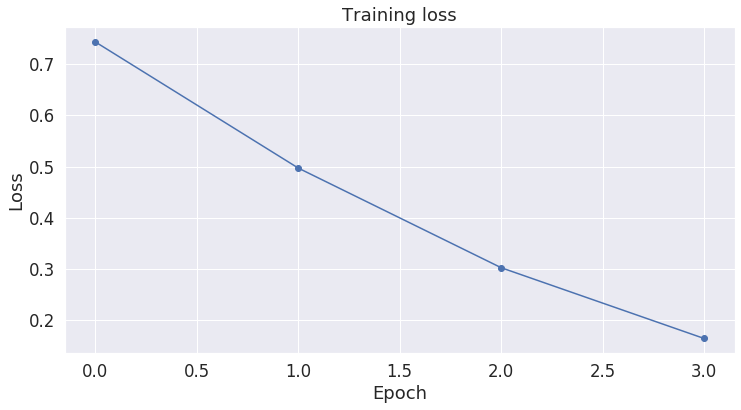

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Homework
Try improving Loss & Accuracy by adjusting hyperparameters 